### IMPORTS

In [31]:
import pandas as pd
import os
import email
import email.policy
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from string import punctuation
from gensim.parsing.preprocessing import STOPWORDS
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from wordcloud import WordCloud
import matplotlib.pyplot as plt

### CARREGANDO BASE DE DADOS

In [32]:
arquivosNormais = [nomeArquivo for nomeArquivo in (os.listdir("./Database/ham")) if len(nomeArquivo) > 20]
arquivosSpam = [nomeArquivo for nomeArquivo in (os.listdir("./Database/spam")) if len(nomeArquivo) > 20]

In [33]:
def carregarEmail(tipo, arquivo):
    caminho = ""

    if tipo == "spam":
        caminho = "./Database/spam"
    if tipo == "ham":
        caminho = "./Database/ham"

    with open(f"{caminho}/{arquivo}", "rb") as file:
        return email.parser.BytesParser(policy=email.policy.default).parse(file)


emailsNormais = [carregarEmail("ham", arquivo) for arquivo in arquivosNormais]
emailsSpam = [carregarEmail("spam", arquivo) for arquivo in arquivosSpam]

#Base de dados secundaria
secondaryDatabaseOnlySpam = pd.read_csv('onlySpam.csv',delimiter=',').drop(columns=["Unnamed: 0"])
arquivosSpamSecondary = [f"spam{i+len(arquivosSpam)}" for i in range(len(secondaryDatabaseOnlySpam))]

In [34]:
#Criando nomes para trocar no dataframe
for i in range(len(arquivosNormais)):
    arquivosNormais[i] = f"ham{i}"

for i in range(len(arquivosSpam)):
    arquivosSpam[i] = f"spam{i}"

emailsNome = arquivosNormais + arquivosSpam

emailsNome += arquivosSpamSecondary

emails = emailsNormais + emailsSpam

### Exemplo de email

In [35]:
aux = emailsNormais[0]

for i in aux.keys():
    print(f"{i} : {aux[i]}")

print('\n')
print('Conteudo:', aux.get_content())

Return-Path : <exmh-workers-admin@example.com>
Delivered-To : zzzz@localhost.netnoteinc.com
Received : from localhost (localhost [127.0.0.1])	by phobos.labs.netnoteinc.com (Postfix) with ESMTP id D03E543C36	for <zzzz@localhost>; Thu, 22 Aug 2002 07:36:16 -0400 (EDT)
Received : from localhost (localhost [127.0.0.1])	by phobos.labs.netnoteinc.com (Postfix) with ESMTP id D03E543C36	for <zzzz@localhost>; Thu, 22 Aug 2002 07:36:16 -0400 (EDT)
Received : from localhost (localhost [127.0.0.1])	by phobos.labs.netnoteinc.com (Postfix) with ESMTP id D03E543C36	for <zzzz@localhost>; Thu, 22 Aug 2002 07:36:16 -0400 (EDT)
Received : from localhost (localhost [127.0.0.1])	by phobos.labs.netnoteinc.com (Postfix) with ESMTP id D03E543C36	for <zzzz@localhost>; Thu, 22 Aug 2002 07:36:16 -0400 (EDT)
Delivered-To : zzzz@localhost.netnoteinc.com
Received : from localhost (localhost [127.0.0.1])	by phobos.labs.netnoteinc.com (Postfix) with ESMTP id D03E543C36	for <zzzz@localhost>; Thu, 22 Aug 2002 07:36:16 

In [36]:
# Pegando estruturas presentes no email

def get_email_structure(email):
    if isinstance(email, str):
        return email

    payload = email.get_payload()

    if isinstance(payload, list):
        lista = []
        for sub_email in payload:
            lista.append(get_email_structure(sub_email))

        return "Estruturas do email:", lista

    else:

        return email.get_content_type()


emailsNormaisMultipart = get_email_structure(emailsNormais[634])
emailsNormaisMultipart

('Estruturas do email:', ['text/plain', 'text/html'])

### Mostrando exemplo de um email com mais de uma estrutura

In [37]:
for email in emailsNormais[634].walk():
    print(email)

Return-Path: <fork-admin@xent.com>
Delivered-To: yyyy@localhost.example.com
Received: from localhost (jalapeno [127.0.0.1])
	by jmason.org (Postfix) with ESMTP id C2C2316F16
	for <jm@localhost>; Fri, 13 Sep 2002 13:37:26 +0100 (IST)
Received: from jalapeno [127.0.0.1]
	by localhost with IMAP (fetchmail-5.9.0)
	for jm@localhost (single-drop); Fri, 13 Sep 2002 13:37:26 +0100 (IST)
Received: from xent.com ([64.161.22.236]) by dogma.slashnull.org
    (8.11.6/8.11.6) with ESMTP id g8CNsQC20509 for <jm@jmason.org>;
    Fri, 13 Sep 2002 00:54:27 +0100
Received: from lair.xent.com (localhost [127.0.0.1]) by xent.com (Postfix)
    with ESMTP id A31B02940D3; Thu, 12 Sep 2002 16:51:04 -0700 (PDT)
Delivered-To: fork@example.com
Received: from web13003.mail.yahoo.com (web13003.mail.yahoo.com
    [216.136.174.13]) by xent.com (Postfix) with SMTP id 5696629409A for
    <fork@xent.com>; Thu, 12 Sep 2002 16:50:13 -0700 (PDT)
Message-Id: <20020912235313.4003.qmail@web13003.mail.yahoo.com>
Received: from

### Transformando estruturas do email que sao html para texto

In [38]:
def html_to_text(email):
    try:
        soup = BeautifulSoup(email.get_content(), 'html.parser')
        return soup.text.replace('\n\n', '')
    except:
        return "empty"


def email_to_text(email):
    for emailParts in email.walk():
        if emailParts.get_content_type() not in ['text/plain', 'text/html']:
            continue

        try:
            emailPartsContent = emailParts.get_content()
        except:
            emailPartsContent = str(emailParts.get_payload())

        if emailParts.get_content_type() == 'text/plain':
            return emailPartsContent
        else:
            return html_to_text(emailParts)


email_to_text(emailsNormais[0])

'    Date:        Wed, 21 Aug 2002 10:54:46 -0500\n    From:        Chris Garrigues <cwg-dated-1030377287.06fa6d@DeepEddy.Com>\n    Message-ID:  <1029945287.4797.TMDA@deepeddy.vircio.com>\n\n\n  | I can\'t reproduce this error.\n\nFor me it is very repeatable... (like every time, without fail).\n\nThis is the debug log of the pick happening ...\n\n18:19:03 Pick_It {exec pick +inbox -list -lbrace -lbrace -subject ftp -rbrace -rbrace} {4852-4852 -sequence mercury}\n18:19:03 exec pick +inbox -list -lbrace -lbrace -subject ftp -rbrace -rbrace 4852-4852 -sequence mercury\n18:19:04 Ftoc_PickMsgs {{1 hit}}\n18:19:04 Marking 1 hits\n18:19:04 tkerror: syntax error in expression "int ...\n\nNote, if I run the pick command by hand ...\n\ndelta$ pick +inbox -list -lbrace -lbrace -subject ftp -rbrace -rbrace  4852-4852 -sequence mercury\n1 hit\n\nThat\'s where the "1 hit" comes from (obviously).  The version of nmh I\'m\nusing is ...\n\ndelta$ pick -version\npick -- nmh-1.0.4 [compiled on fuchsia.c

### Fazendo Pre-Processamento das palavras

In [39]:
def removePunctuation(text):
    ponctuation = list(punctuation)

    for i in ponctuation:
        text = text.replace(i, " ")

    return text


def wordsPreProcessing(email):
    if email is None:
        return 'empty'

    newText = ""

    stopWords = set(stopwords.words('english') + list(STOPWORDS))
    stopWords.add("subject")
    lemmatizer = WordNetLemmatizer()
    wordTokenize = RegexpTokenizer(r'\w+')

    for text in wordTokenize.tokenize(email.lower()):
        text = removePunctuation(text)
        if text not in stopWords and not text.isdigit():
            newText += lemmatizer.lemmatize(text) + " "

    return newText

### Representação vetorial utilizando bag of words

In [40]:
def bagOfWord(emails):
    wordCount = {}

    for email in emails:
        for i in email.split():
            if i not in wordCount.keys():
                wordCount[i] = 1
            else:
                wordCount[i] += 1

    return wordCount

### Adicionando todos os textos dos emails pre processados em um vetor

In [41]:
emailsText = []

for email in emails:
    emailsText.append(wordsPreProcessing
                      (email_to_text(email)))

for email in secondaryDatabaseOnlySpam["text"].array:
    emailsText.append(wordsPreProcessing(email))


## Nuvem de palavras

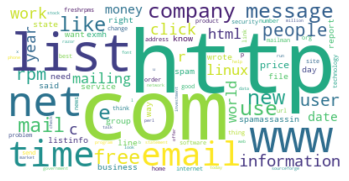

In [42]:
wordCount = bagOfWord(emailsText)

wordsForCloud = sorted(wordCount.items(),key=lambda i: i[1],reverse=True)[:100]
wordsForCloud = dict(wordsForCloud)
wordCloud = WordCloud(background_color="white")
wordCloud.generate_from_frequencies(wordsForCloud)

plt.imshow(wordCloud,interpolation="bilinear")
plt.axis("off")
plt.show()

## Histograma

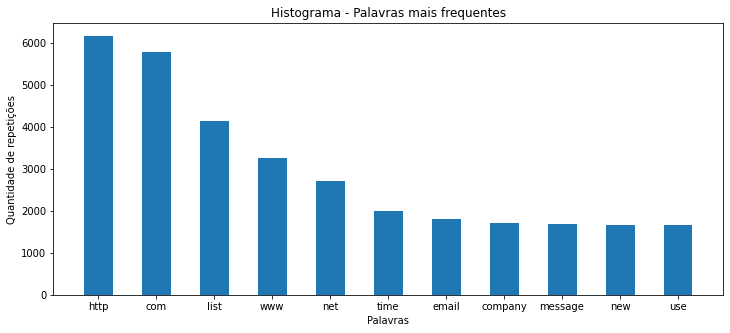

In [43]:
wordsForHistogram = sorted(wordCount.items(),key=lambda i: i[1],reverse=True)[:11]
wordsForHistogram = dict(wordsForHistogram)
plt.figure(figsize=(12,5))
plt.bar(wordsForHistogram.keys(),wordsForHistogram.values(),width=0.5)
plt.title('Histograma - Palavras mais frequentes')
plt.ylabel('Quantidade de repetições')
plt.xlabel('Palavras')
plt.show()

### Representação vetorial utilizando TF IDF

In [44]:
tfidfVectorizer = TfidfVectorizer(analyzer="word", max_features=2500)
tfidfTransform = tfidfVectorizer.fit_transform(emailsText)

print(tfidfTransform)

  (0, 1284)	0.03205857331254053
  (0, 1328)	0.036136482621743314
  (0, 1286)	0.05459247687035483
  (0, 1059)	0.018025361921460932
  (0, 1842)	0.09934884862353248
  (0, 1327)	0.03177529554341739
  (0, 2461)	0.17980541242541126
  (0, 781)	0.15693146624307805
  (0, 2244)	0.038391460261596996
  (0, 1173)	0.048103217530437364
  (0, 1295)	0.05223893059475307
  (0, 2265)	0.04021880115838141
  (0, 1883)	0.06996381204528931
  (0, 517)	0.058423851747898985
  (0, 1818)	0.05773306556545683
  (0, 3)	0.051082574317547286
  (0, 63)	0.05267471370851467
  (0, 536)	0.03878769510701364
  (0, 884)	0.045921216673521406
  (0, 392)	0.047033154185909413
  (0, 1225)	0.07058962255679747
  (0, 500)	0.061973302569051494
  (0, 1976)	0.054943598371533134
  (0, 1278)	0.039877318821720985
  (0, 27)	0.04750794678481629
  :	:
  (4550, 917)	0.06114611229083652
  (4550, 1529)	0.35701385205182357
  (4550, 789)	0.0681745766355502
  (4550, 1115)	0.049636441499413174
  (4550, 1128)	0.09176074503329511
  (4550, 1490)	0.079303

In [45]:
tfidfLabels = tfidfVectorizer.get_feature_names_out()
tfidfLabels

array(['7gsolb', 'aa', 'ability', ..., 'zip', 'zone', 'zonedubai'],
      dtype=object)

### Criando Dataframe

In [46]:
dfTfidfArray = pd.DataFrame(data=tfidfTransform.toarray(), index=emailsNome, columns=tfidfLabels)

In [47]:
dfTfidfArray

,7gsolb,aa,ability,able,absolutely,abuse,ac,acceleration,accept,acceptance,...,yes,yesterday,york,young,zawodny,zero,zimbabwe,zip,zone,zonedubai
ham0,0.000000,0.0,0.000000,0.051083,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ham1,0.147225,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ham2,0.070674,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ham3,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ham4,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
spam1995,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
spam1996,0.000000,0.0,0.070192,0.000000,0.0,0.0,0.0,0.0,0.0,0.043321,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
spam1997,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
spam1998,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Preparando array de Targets com 1 para Spam e 0 para Normal

In [48]:
arrayTargetsNormais = [0 for _ in arquivosNormais]

arrayTargetsSpam = [1 for _ in range(len(arquivosSpam)+len(arquivosSpamSecondary))]

targetsArray = arrayTargetsNormais + arrayTargetsSpam

print(len(targetsArray))
print(targetsArray)

4551
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

### Adicionando a coluna de Targets no Dataframe

In [49]:
dfTfidfArray.insert(len(dfTfidfArray.columns), "Target", targetsArray, True)
dfTfidfArray = dfTfidfArray.sample(frac=1)
dfTfidfArray

,7gsolb,aa,ability,able,absolutely,abuse,ac,acceleration,accept,acceptance,...,yesterday,york,young,zawodny,zero,zimbabwe,zip,zone,zonedubai,Target
spam1737,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.107578,0.0,0.0,0.0,0.000000,0.000000,0.0,1
spam48,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,1
spam1510,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,1
spam296,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.132855,0.000000,0.0,1
spam1260,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ham473,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0
ham1038,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0
spam918,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.024172,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.131827,0.0,1
spam1759,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.036019,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,1


### Redimensionando dimensões usando TSNE e plotando gráfico bidimensional

C:\Users\victo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\victo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


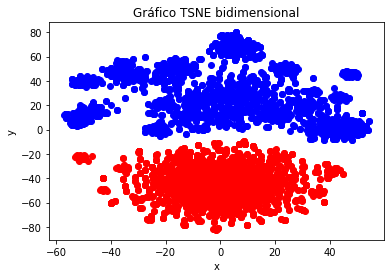

In [50]:
model = TSNE(n_components=2, random_state=0)
array_red = model.fit_transform(dfTfidfArray)

df_tsne = pd.DataFrame(array_red)

target = dfTfidfArray["Target"].array

df_tsne['Target'] = target

df_tsne_ham = df_tsne[df_tsne['Target'] == 0]

df_tsne_spam = df_tsne[df_tsne['Target'] == 1]

plt.scatter(df_tsne_ham[0].array,df_tsne_ham[1].array,marker='o',color='blue')

plt.scatter(df_tsne_spam[0].array,df_tsne_spam[1].array,marker='o',color='red')

plt.title('Gráfico TSNE bidimensional')
plt.xlabel('x')
plt.ylabel('y')

plt.show()

### Redimensionando dimensões usando PCA e plotando gráfico bidimensional

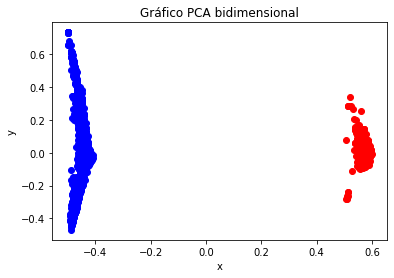

In [51]:

model = PCA(n_components=2, svd_solver='full')
array_redPCA = model.fit_transform(dfTfidfArray)

df_pca = pd.DataFrame(array_redPCA)

targetPCA = dfTfidfArray["Target"].array

df_pca['Target'] = targetPCA

df_pca_ham = df_pca[df_pca['Target'] == 0]

df_pca_spam = df_pca[df_pca['Target'] == 1]

plt.scatter(df_pca_ham[0].array,df_pca_ham[1].array,marker='o',color='blue')

plt.scatter(df_pca_spam[0].array,df_pca_spam[1].array,marker='o',color='red')

plt.title('Gráfico PCA bidimensional')
plt.xlabel('x')
plt.ylabel('y')

plt.show()